In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.typing as npt

from scipy.optimize import curve_fit

from stellar_stream import StellarStream

from scipy.stats import pearsonr
import pandas as pd

In [30]:
### Load all simulations into StellarStream type and put in a dictionary for easy access.

from pathlib import Path
DATA_DIR = Path('../../data/sample')


simulations = {}

for sim_data in DATA_DIR.glob('*.npz'):
    simulation_number = sim_data.name.removeprefix('simdatag').removesuffix('.npz')
    simulations[simulation_number] = (StellarStream.from_simulation(simulation_number, sim_data)
                                            .select("restrict_phi1", phi1_lim=(-110, 10))
                                            .select("restrict_phi2", phi2_lim=15.0)
                                            .run_analysis(name="gaussian_process_detrend", n_bins=40)
                                            .select("restrict_phi1", phi1_lim=(-100, 0))
                                            .select("restrict_phi2", phi2_lim=6.0)
    )

In [15]:
def power_law(x, a, b):
        return a * x**b


def linear(x, m, b):
        return m * x + b

In [8]:
def analyze_simulations_fixed_slope(
    simulations,
    ids,
    skip_first_xbin=True,
    min_positive_points: int = 6,
    ddof_std: int = 0,
    compute_amp_err: bool = True,
    fit_band: tuple | None = None,  # (xmin, xmax) in same units as x (e.g. Hz). Use None for no band filtering.
    **kwargs
):
    """
    Parameters:
      simulations: dict-like mapping id (str/int) -> StellarStream object
      ids: iterable of ids (strings or ints)
      skip_first_xbin: whether to drop the first bin
      min_positive_points: minimum (#) positive points after subtracting c to attempt a fit
      ddof_std: ddof for std_vlos
      compute_amp_err: whether to estimate an error on amplitude (simple standard error in log domain)
      fit_band: optional tuple (xmin, xmax). If provided, only points with xmin <= x <= xmax are used for the fits.
                Example: fit_band=(0.1, 1.0) will fit only between 0.1 and 1.0 Hz.
    Returns:
      df, mean_slope, (pearson_r, pearson_p), fig
    """
    ids_list = [str(i) for i in list(ids)]
    rows = []
    fit_cache = {}  # store x,y,c,y_sub,b,a,log_a for each successful sim

    for sid in ids_list:
        if sid not in simulations:
            # skip missing sims quietly
            continue
        sim = simulations[sid]
        try:
            x, y = sim.power_spectrum(**kwargs)
        except Exception:
            # skip sims that fail to produce a spectrum
            continue
        x = np.asarray(x)
        y = np.asarray(y)
        if skip_first_xbin:
            x = x[1:]
            y = y[1:]
        # sort by x ascending (so last entries are highest-k)
        order = np.argsort(x)
        x_sorted = x[order]
        y_sorted = y[order]
        n = len(x_sorted)
        if n == 0:
            continue


        # keep only points with x>0 and y_sorted>0 (required for log)
        mask_pos = (x_sorted > 0) & (y_sorted > 0) & np.isfinite(y_sorted) & np.isfinite(x_sorted)

        # apply user-specified band if given
        if fit_band is not None:
            xmin, xmax = fit_band
            if xmin is not None:
                mask_pos &= (x_sorted >= xmin)
            if xmax is not None:
                mask_pos &= (x_sorted <= xmax)

        if np.sum(mask_pos) < min_positive_points:
            # skip if too few usable bins after subtraction and band filtering
            continue

        x_pos = x_sorted[mask_pos]
        y_pos = y_sorted[mask_pos]

        # log-log fit for slope b_i and intercept
        lx = np.log(x_pos)
        ly = np.log(y_pos)
        # fit linear model ly = b * lx + intercept  (np.polyfit returns [b, intercept])
        b_i, intercept = np.polyfit(lx, ly, 1)
        log_a_i = intercept
        a_i = float(np.exp(log_a_i))

        # store (note: store the band-filtered x_pos/y_pos used for the fit)
        fit_cache[sid] = {
            "x": x_sorted,
            "y": y_sorted,
            "x_pos": x_pos,
            "y_pos": y_pos,
            "b": float(b_i),
            "log_a": float(log_a_i),
            "a": a_i
        }
        # std of line of sight velocities
        try:
            std_vlos = float(np.asarray(sim.vlos).std(ddof=ddof_std))
        except Exception:
            std_vlos = np.nan

        rows.append({"id": sid, "std_vlos": std_vlos, "b": float(b_i), "a": a_i})

    if len(rows) == 0:
        raise RuntimeError("No successful fits found (too few positive points after c-subtraction / band filtering).")

    df = pd.DataFrame(rows)

    # 3) mean slope across sims
    mean_b = float(df["b"].mean())

    # 4) Fix slope mean_b and recompute amplitude per sim (in log domain)
    amplitudes = []
    amp_errs = []
    for sid in df["id"].astype(str):
        info = fit_cache[sid]
        x_pos = info["x_pos"]
        y_pos = info["y_pos"]
        
        lx = np.log(x_pos)
        ly = np.log(y_pos)

        p0_amp = [np.log(info.get('a', 1.0))]
        popt_amp, pcov_amp = curve_fit(lambda x, a_prime: linear(x, mean_b, a_prime), lx, ly, p0=p0_amp, bounds=(-np.inf, np.inf), maxfev=20000)
        a_hat = float(np.exp(popt_amp[0]))
        if compute_amp_err and pcov_amp is not None:
            perr = np.sqrt(np.diag(pcov_amp))
            stderr_log_a = float(perr[0])               # std error on log(a)
            amp_err = a_hat * stderr_log_a  
        else:
            amp_err = np.nan
        
        amplitudes.append(a_hat)
        amp_errs.append(amp_err)

    df["amplitude"] = amplitudes
    df["amp_err"] = amp_errs

    # Pearson correlation between std_vlos and amplitude
    # require at least 2 valid points
    mask_valid = np.isfinite(df["std_vlos"]) & np.isfinite(df["amplitude"])
    if mask_valid.sum() >= 2:
        r, pval = pearsonr(df.loc[mask_valid, "std_vlos"], df.loc[mask_valid, "amplitude"])
    else:
        r, pval = np.nan, np.nan

    # Plot results: amplitude vs std_vlos with errorbars and linear fit line
    fig, ax = plt.subplots(figsize=(6,4))
    xs = df["std_vlos"].values
    ys = df["amplitude"].values
    yerr = df["amp_err"].values if "amp_err" in df.columns else None
    ax.errorbar(xs, ys, yerr=yerr, fmt='o', capsize=3)
    ax.set_xlabel("Std. Dev. of Line-of-Sight Velocity")
    ax.set_ylabel("Amplitude a (log-fit)")
    ax.set_title(f"Amplitude vs Std. Dev.  —  mean slope b = {mean_b:.3f}\nPearson r={r:.3f}, p={pval:.3g}")
    ax.grid(True)

    # simple linear regression line for visualization (unweighted)
    finite_mask = np.isfinite(xs) & np.isfinite(ys)
    if finite_mask.sum() >= 2:
        coeffs = np.polyfit(xs[finite_mask], ys[finite_mask], 1)
        line_x = np.linspace(np.nanmin(xs[finite_mask]), np.nanmax(xs[finite_mask]), 200)
        ax.plot(line_x, coeffs[0]*line_x + coeffs[1], label=f"lin fit slope={coeffs[0]:.3g}")
        ax.legend()

    # annotate with ids (small offset)
    for _, row in df.iterrows():
        ax.annotate(row["id"], (row["std_vlos"], row["amplitude"]), textcoords="offset points", xytext=(3,3), fontsize=8)

    plt.tight_layout()

    return df, mean_b, (r, pval), fig


In [16]:
def plot_sim_power(df, sim_idx, fit_band=(-100, 100), include_first=True, loglog=True, ax=None):
    """
    Plot power spectrum of one simulation against its fitted model.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with fitted parameters. Must have columns:
        ['a_hat', 'b'] for amplitude and slope.
    sim_idx : int
        Index (row number) of the simulation in df (and in arrays).
    include_first: bool
        If True, include the first data point in the plot. Gives
        the option since it can skew the log-log plot.
    loglog : bool
        If True, plot in log-log scale.
    ax : matplotlib.axes.Axes, optional
        Axis to plot on. Creates new one if None.
    """

    if ax is None:
        fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
        
    first=slice(None,None) if include_first else slice(1,None)
    

    # grab data
    k, ps = simulations[sim_idx].power_spectrum(precision=precision, detrend_deg=2, window='hann')

    xmin, xmax = fit_band
    mask_pos = (k > 0) & (ps > 0) & np.isfinite(ps) & np.isfinite(k)
    mask_pos &= (k >= xmin)
    mask_pos &= (k <= xmax)

    # grab model parameters
    a = df.loc[df['id'] == sim_idx, "amplitude"].iloc[0]

    # compute model
    b_mean = df['b'].mean()
    ps_model = a * k**b_mean
    
    # apply mask
    k=k[mask_pos]
    ps_model=ps_model[mask_pos]
    ps=ps[mask_pos]

    # plot data
    ax[0].plot(k[first], ps[first], 'o', ms=3, alpha=0.6, label=f"Sim {sim_idx} data")

    # plot model
    ax[0].plot(k[first], ps_model[first], 'r-', lw=2, label=f"Model: P(k)={a:.2g} k^{b_mean:.2f}")

    if loglog:
        ax[0].set_xscale("log")
        ax[0].set_yscale("log")
        
        ax[1].set_xscale("log")
        ax[1].set_yscale("log")

    ax[0].set_xlabel("k")
    ax[0].set_ylabel("P(k)")
    ax[0].legend()
    ax[0].set_title(f"Simulation {sim_idx}: slope={b_mean:.2f}")

    residuals = np.abs(ps[first] - ps_model[first]) if loglog else ps[first] - ps_model[first]

    # plot residuals
    ax[1].plot(k[first], residuals, 'o', ms=3, alpha=0.6, label=f"Sim {sim_idx} residuals")
    ax[1].set_xlabel("k")
    ax[1].set_ylabel("Residuals")
    ax[1].legend()

    return ax

mean slope b: -2.723614922656574 pearson r,p: (np.float64(0.413819091593594), np.float64(0.07819052208275501))


/var/folders/xy/gr1cyhld4mz7nt6bz8f0j3kc0000gn/T/ipykernel_36903/851460216.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


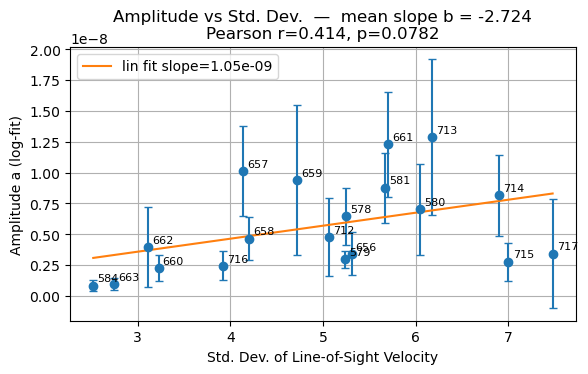

In [9]:
band = (0.005, 0.07)
precision = 0.05

simulations_to_use = list(filter(lambda k: k not in ['718', '583', '582'], simulations.keys()))

df, mean_b, (r,p), fig = analyze_simulations_fixed_slope(
    simulations, 
    simulations_to_use, 
    fit_band=band, 
    detrend_deg=2,
    precision=precision,
    window='hann'
    )
df.head(); print("mean slope b:", mean_b, "pearson r,p:", (r,p))
fig.show()

mean slope b: -2.888971063323103 pearson r,p: (np.float64(0.20529621627965908), np.float64(0.359387614783079))


/var/folders/xy/gr1cyhld4mz7nt6bz8f0j3kc0000gn/T/ipykernel_79550/4186843351.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_all.show()


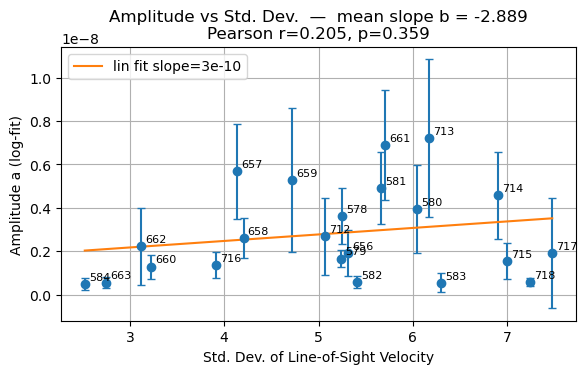

In [9]:
#simulations_to_use = list(filter(lambda k: k not in ['718', '583', '582'], simulations.keys()))
simulations_to_use = simulations.keys()

df_all, mean_b_all, (r_all,p_all), fig_all = analyze_simulations_fixed_slope(
    simulations, 
    simulations_to_use, 
    fit_band=band, 
    detrend_deg=2,
    precision=precision,
    window='hann'
    )
df_all.head(); print("mean slope b:", mean_b_all, "pearson r,p:", (r_all,p_all))
fig_all.show()

/var/folders/xy/gr1cyhld4mz7nt6bz8f0j3kc0000gn/T/ipykernel_79550/3440240659.py:40: RuntimeWarning: divide by zero encountered in power
  ps_model = a * k**b_mean


array([<Axes: title={'center': 'Simulation 718: slope=-2.89'}, xlabel='k', ylabel='P(k)'>,
       <Axes: xlabel='k', ylabel='Residuals'>], dtype=object)

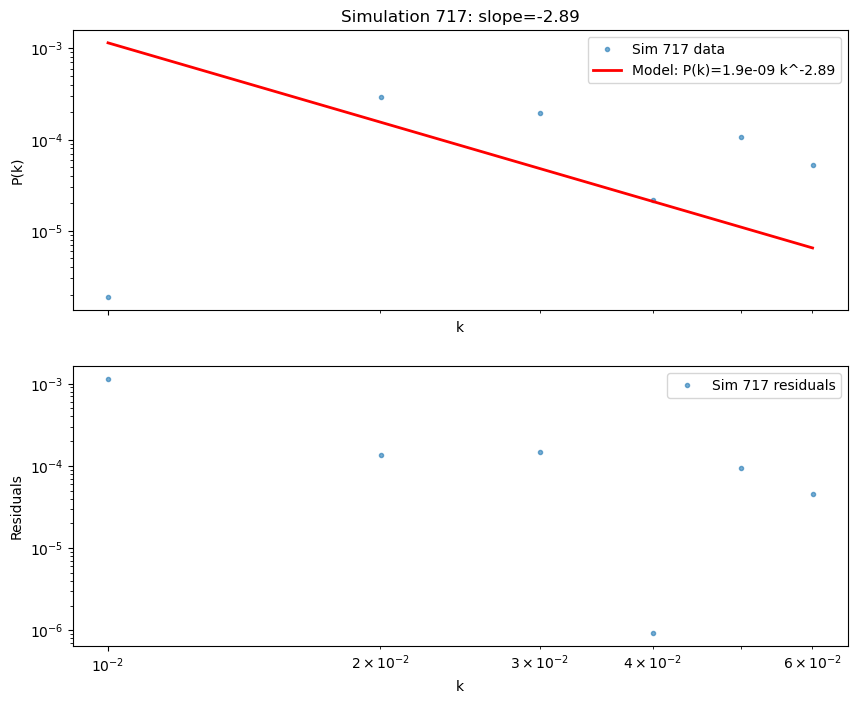

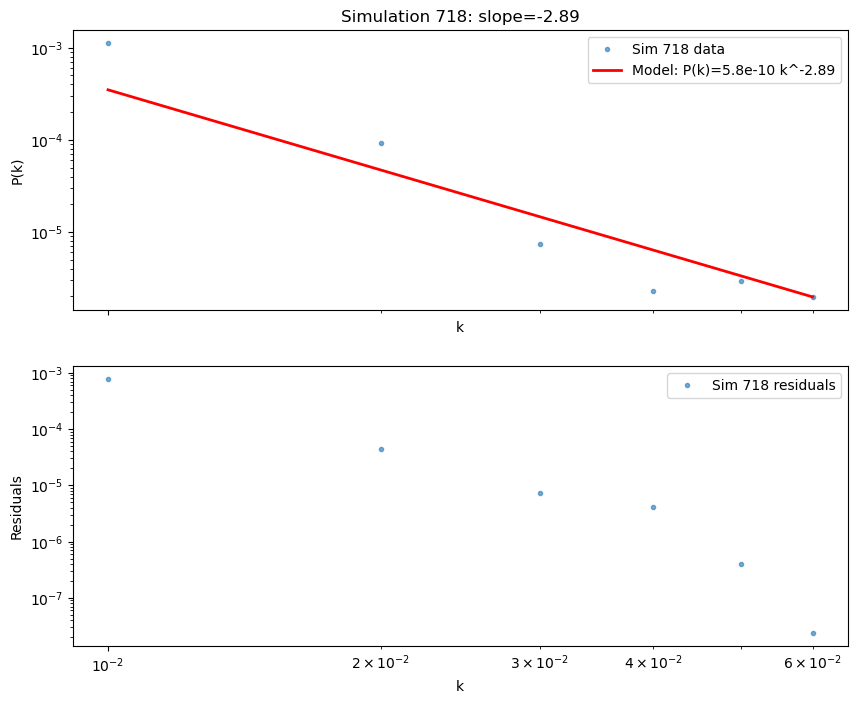

In [17]:
#plot_sim_power(df, '583', fit_band=band, include_first=True, loglog=True)
plot_sim_power(df_all, '717', fit_band=band, include_first=True, loglog=True) # Well Fit
plot_sim_power(df_all, '718', fit_band=band, include_first=True, loglog=True) # Outlier